In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device being used is {device}")

Device being used is cuda


In [4]:
import seaborn as sns
sns.set()

In [5]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
class NN_general(nn.Module):
    def_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def __init__(self, stack = def_stack):
        super(NN_general, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = stack

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
def gen_nn(sizes):
    modules = [nn.Linear(28*28, sizes[0]), nn.ReLU()]
    for i in range(len(sizes) - 1):
        modules.append(nn.Linear(sizes[i], sizes[i + 1]))
        modules.append(nn.ReLU())
    modules.append(nn.Linear(sizes[-1], 10))

    return NN_general(stack = nn.Sequential(*modules))

In [24]:
class NN_tester:
    def __init__(self, test_data, train_data, model, num_epoch = 5, batch_size = 64, learning_rate = 1e-3):
        self.epochs = num_epoch
        self.model = model.to(device)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.SGD((self.model).parameters(), lr = learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.test_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.train_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    def train_loop(self):
        for X, y in self.test_dataloader:
            # prediction
            pred = self.model(X.to(device))
            loss = self.loss_fn(pred, y.to(device))

            # backpropagate
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def train_loss_calc(self):
        size = len(self.train_dataloader.dataset)
        num_batches = len(self.train_dataloader)
        train_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in self.train_dataloader:
                y = y.to(device)
                pred = self.model(X.to(device))
                train_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        train_loss /= num_batches
        correct /= size

        return train_loss

    def test_loop(self):
        size = len(self.test_dataloader.dataset)
        num_batches = len(self.test_dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in self.test_dataloader:
                y = y.to(device)
                pred = self.model(X.to(device))
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size

        return test_loss, correct

    def evaluate(self):
        train_loss_arr = []
        test_loss_arr = []
        accuracy_arr = []
        for i in tqdm(range(self.epochs)):
            # print(f"Epoch {i + 1}")
            self.train_loop()
            train_loss = self.train_loss_calc()
            test_loss, accuracy = self.test_loop()

            train_loss_arr.append(train_loss)
            test_loss_arr.append(test_loss)
            accuracy_arr.append(accuracy)

        print("DONE!")

        return train_loss_arr, test_loss_arr, accuracy_arr

In [13]:
tester = NN_tester(test_data=test_data, train_data=training_data, model = NN_general())
test_loss, train_loss, accuracy = tester.evaluate()

100%|██████████| 5/5 [01:38<00:00, 19.67s/it]

DONE!


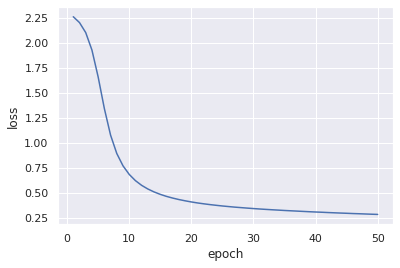

In [10]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(np.linspace(1, tester.epochs, tester.epochs), test_loss)

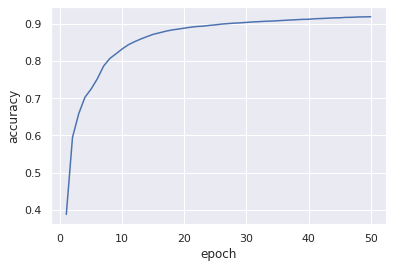

In [11]:
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(np.linspace(1, tester.epochs, tester.epochs), accuracy)

In [ ]:
epochs = 50

storage = []

for depth in [1, 2, 3, 4]:
    tester = NN_tester(test_data=test_data, train_data=training_data, model = gen_nn([512]*depth), num_epoch = epochs)
    train_loss, test_loss, accuracy = tester.evaluate()
    # model_params = tester.model.state_dict()
    stored_dict = {"nodes": 512, "layers": depth, "train_loss_array": train_loss, "test_loss_array": test_loss, "accuracy_array": accuracy, "epochs": epochs, "batch_size": tester.batch_size, "lr": tester.learning_rate}
    storage.append(stored_dict)

  2%|▏         | 1/50 [00:11<09:35, 11.74s/it]

In [18]:
storage

[{'nodes': 512,
  'layers': 2,
  'loss_array': [2.1966726420084637,
   1.9031384471257529,
   1.300484405231476,
   0.8716286612828572,
   0.6684528525670369],
  'accuracy_array': [0.5906,
   0.6880666666666667,
   0.7536666666666667,
   0.8147833333333333,
   0.8382166666666667],
  'epochs': 5,
  'batch_size': 32,
  'lr': 0.001},
 {'nodes': 512,
  'layers': 2,
  'loss_array': [2.2533380629411384,
   2.181568036709767,
   2.057971551728401,
   1.8458941763143804,
   1.5434259002142623],
  'accuracy_array': [0.3812,
   0.5621166666666667,
   0.63975,
   0.6897,
   0.7245333333333334],
  'epochs': 5,
  'batch_size': 64,
  'lr': 0.001},
 {'nodes': 512,
  'layers': 2,
  'loss_array': [2.2747121950202405,
   2.2492936638626717,
   2.2181984544562887,
   2.1782048521265547,
   2.125690269571886],
  'accuracy_array': [0.32381666666666664,
   0.4986333333333333,
   0.5876833333333333,
   0.6259,
   0.6456],
  'epochs': 5,
  'batch_size': 128,
  'lr': 0.001},
 {'nodes': 512,
  'layers': 2,
  'l

In [16]:
import pickle

with open('layer_width.pkl', 'wb') as f:
    pickle.dump(storage, f)